- ETRI 데이터 일부 train set으로 넣어주는 것 검토
- ETRI 데이터는 문서 단위로 넣어주는 것도 고려

In [1]:
!nvidia-smi

Tue Jul 26 14:31:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3D:00.0 Off |                  N/A |
| 30%   24C    P8    16W / 350W |      1MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:41:00.0 Off |                  N/A |
| 30%   

## module import

In [2]:
import torch
import pandas as pd
import numpy as np; import random
import os

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

from transformers import BertForSequenceClassification, BertTokenizerFast

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
os.listdir()

['output',
 'fine_tuning(working).ipynb',
 'total_v2.1.csv',
 'vocab',
 '40ep_train9',
 'run_a10.sh',
 'run_slurm.sh',
 '.ipynb_checkpoints',
 'wandb',
 'etri_changdae_AFTER.csv',
 'error_test_v2.csv',
 'requirements.txt',
 'SLURM.n013.676751.out',
 'SLURM.n013.676751.err',
 '__pycache__',
 'src',
 'logs',
 'run_bert.py',
 'run_bert.sh',
 'SLURM.n005.683701.out',
 'SLURM.n005.683701.err',
 '.nfs0000000783e4d85b000145df',
 '.nfs0000000783e4d85c000145e0',
 'SLURM.n005.684658.out',
 'SLURM.n005.684658.err',
 'SLURM.n005.685078.out',
 'SLURM.n005.685078.err',
 'SLURM.n006.685705.out',
 'SLURM.n006.685705.err',
 'SLURM.n007.685752.out',
 'SLURM.n007.685752.err',
 'SLURM.n008.685787.out',
 'SLURM.n008.685787.err',
 'SLURM.n008.686353.out',
 'SLURM.n008.686353.err',
 'fine_tuning_v0_3(focal_loss).ipynb',
 'fine_tuning_v0_4(train_etri).ipynb',
 'fine_tuning_v1_0.ipynb',
 'train.csv',
 'val.csv',
 'test.csv',
 'fine_tuning_v0_5(train_etri+focal1).ipynb']

In [5]:
vocab_path: str = './vocab'
model_path: str = './40ep_train9/'
data_path: str = './total_v2.1.csv'
test_path: str = './etri_changdae_AFTER.csv'
output_path: str = './output/train_etri'

In [6]:
# randomness 제어
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
set_seed(12345)

In [7]:
import wandb
# pw

wandb: Appending key for api.wandb.ai to your netrc file: /home1/hyez/.netrc


## Load Dataset

In [8]:
df = pd.read_csv(data_path)
print(df.shape)
print(df.isna().sum())
df.head()

(185554, 3)
text      5
tag       0
source    0
dtype: int64


,text,tag,source
0,비접촉식 상황인지 센서: 움직이는 대상물 탐지센서,기술의 파급효과,etri
1,"비접촉 생체신호 모니터링 의료용기기, 헬스케어모니터링 기기",기술의 파급효과,etri
2,차량내 운전자 상태 모니터링 센서,기술의 파급효과,etri
3,"강설량 측정, 비파괴 벽투과 센서",기술의 파급효과,etri
4,재난 안전 모니터링용 센서 및 안전 사고후 비가시 영역 탐지 센서,기술의 파급효과,etri


In [9]:
# 결측치 제거
df = df.dropna()

In [10]:
s = df.source=='etri' # etri train data에서 제거
df = df[~s].reset_index(drop=True)

In [11]:
test_df = pd.read_csv(test_path, encoding='cp949')
print(test_df.shape)
print(test_df.isna().sum())
test_df.tag = test_df.tag.replace({'기술의필요성':'기술의 필요성'})
test_df.tag = test_df.tag.replace({'기술동향':'기술의 파급효과'})
test_df.head()

(33773, 4)
text      0
tag       0
source    0
doc_id    0
dtype: int64


,text,tag,source,doc_id
0,다매체 다중경로 적응적 네트워크 최적화 기술,기술명,etri,0
1,국방망과 같은 절대적 생존을 요구하는 주요 통신망은 다수개의 망을 설치하여 유사시 ...,기술개요,etri,0
2,"또한, 데이터센터, 에지 클라우드에서는 전송해야 하는 데이터양이 급증하고 있으며, ...",기술개요,etri,0
3,"따라서, 가용한 모든 통신 인프라를 동시에 사용하여 네트워크 자원의 낭비를 막고 통...",기술개요,etri,0
4,본 기술은 다매체 다중경로 네트워크에 대한 적응적 제어 기술을 이용해 트래픽을 여러...,기술개요,etri,0


- input : text
- label : tag

In [12]:
# y dict 생성
possible_labels = df.tag.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

# label encoding
df['labels'] = df.tag.replace(label_dict)

test_df = test_df[test_df.tag.apply(lambda x: x in label_dict.keys())]
test_df['labels'] = test_df.tag.replace(label_dict)

In [14]:
set_seed(12345)
# 70 10 20
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.labels.values, 
                                                  test_size=0.30, random_state=12345, stratify=df.labels.values)
X_val, X_test, y_val, y_test = train_test_split(df.loc[X_val].index.values, df.loc[X_val].labels.values, 
                                                  test_size=0.66, random_state=12345, stratify=df.loc[X_val].labels.values)
train, val, test = df.loc[X_train, ['text', 'labels']].reset_index(drop=True), df.loc[X_val, ['text', 'labels']].reset_index(drop=True), df.loc[X_test, ['text', 'labels']].reset_index(drop=True)
print(train.shape, val.shape, test.shape)

(123381, 2) (17978, 2) (34900, 2)


In [15]:
set_seed(12345)
# doc id 기준으로 split, 20 10 70
etri_test, etri_train= train_test_split(test_df.doc_id.unique(), test_size=0.30, random_state=12345)
etri_train, etri_valid= train_test_split(etri_train, test_size=0.33, random_state=12345)
e_train, e_valid, e_test = test_df.loc[test_df.doc_id.apply(lambda x: x in etri_train), ['text', 'labels']], test_df.loc[test_df.doc_id.apply(lambda x: x in etri_valid), ['text', 'labels']], test_df.loc[test_df.doc_id.apply(lambda x: x in etri_test),['text', 'labels']]
print(e_train.shape, e_valid.shape, e_test.shape)

(2158, 2) (973, 2) (7229, 2)


In [16]:
train, val, test = pd.concat([train, e_train], axis=0), pd.concat([val, e_valid], axis=0), pd.concat([test, e_test], axis=0)
print(train.shape, val.shape, test.shape)

(125539, 2) (18951, 2) (42129, 2)


In [17]:
# make Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)
dataset = DatasetDict({"train": train_dataset, "val": val_dataset, "test": test_dataset})

In [18]:
example = train_dataset[0]
print(example)

{'text': '6)Figure 4에 나타내고 있는 창고 모델은 의류창고를 축소하여 3m  3m  2.4m로 모사하였으며, 벽체는 불연등급의 그라스울과 일반 스티로폼 샌드위치 패널로 구성하였다.', 'labels': 2, '__index_level_0__': 0}


In [19]:
dataset['train'].num_rows

125539

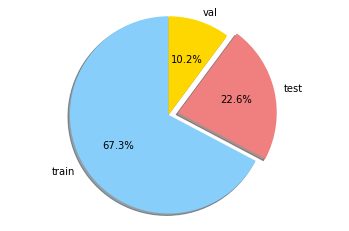

In [20]:
labels = ['train', 'test', 'val']
sizes = [dataset['train'].num_rows, dataset['test'].num_rows, dataset['val'].num_rows]
colors = ['lightskyblue', 'lightcoral', 'gold']#, yellowgreen
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

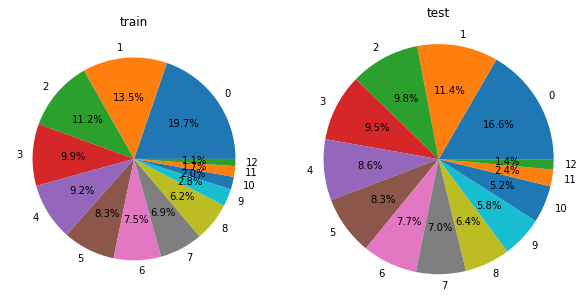

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
labels = list(range(len(label_dict)))
sizes = train.labels.value_counts().tolist()
ax[0].pie(sizes, labels=labels,autopct='%1.1f%%')
ax[0].set_title('train')

sizes = test.labels.value_counts().tolist()
ax[1].pie(sizes, labels=labels,autopct='%1.1f%%')
ax[1].set_title('test')

plt.axis('equal')
plt.show()

## tokenizer load 
- __call__ : https://github.com/huggingface/transformers/blob/v4.20.1/src/transformers/tokenization_utils_base.py#L2409

In [22]:
tokenizer = BertTokenizerFast.from_pretrained(vocab_path, do_lower_case=False, model_max_length=128)
print(tokenizer.__class__)
## vocab 확인
sorted(tokenizer.vocab.items(), key = lambda item: item[1])[:10]

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


[('[PAD]', 0),
 ('[UNK]', 1),
 ('[CLS]', 2),
 ('[SEP]', 3),
 ('[MASK]', 4),
 ('!', 5),
 ('"', 6),
 ('#', 7),
 ('$', 8),
 ('%', 9)]

In [23]:
from typing import Union, List, Dict

def transform(sentences: Union[str, List[str]], tokenizer) -> Dict[str, List[List[int]]]:
    if isinstance(sentences, str):
        sentences = [sentences]
    return tokenizer(text=sentences, add_special_tokens=True, padding=False, truncation=True, max_length = 128) ## Modify

In [24]:
samples = train_dataset[:2]
transformed_samples = transform(samples["text"], tokenizer)

print(samples)
print(transformed_samples)

{'text': ['6)Figure 4에 나타내고 있는 창고 모델은 의류창고를 축소하여 3m  3m  2.4m로 모사하였으며, 벽체는 불연등급의 그라스울과 일반 스티로폼 샌드위치 패널로 구성하였다.', '부분방전 특성인 -q-n 분포를 고찰하기 위해 AVO Co.에서 제작한 부분방전 측정 장치를 이용하여 AC 60  10 kV 전압으로 방전특성을 실험하였다.'], 'labels': [2, 1], '__index_level_0__': [0, 1]}
{'input_ids': [[26, 13, 30658, 2620, 9226, 14602, 10894, 4869, 23013, 19866, 15369, 38916, 2494, 9364, 4870, 34108, 34108, 22, 18, 24, 2677, 2462, 32326, 8399, 16, 38230, 2466, 1090, 2520, 8331, 2490, 13794, 2473, 2970, 2558, 5162, 9948, 2462, 3408, 35331, 6961, 2462, 4980, 5021, 18], [5141, 19711, 5775, 2551, 17, 85, 17, 82, 23567, 15642, 4884, 4893, 26355, 2575, 11837, 18, 5244, 15618, 5141, 19711, 5366, 8175, 5568, 11149, 5584, 4889, 79, 2868, 5917, 4859, 11239, 30332, 6368, 5021, 18]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [25]:
train_ds = train_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)
valid_ds = val_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)
test_ds = test_dataset.map(lambda data: transform(data["text"], tokenizer), remove_columns=["text"], batched=True)

  0%|          | 0/126 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/43 [00:00<?, ?ba/s]

# Model Load

In [27]:
from seq_bert import BertForSequenceClassificationWithFocal

# BERT Pre-trained Model
model = BertForSequenceClassificationWithFocal.from_pretrained(model_path,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      problem_type = "imbalanced_single_label_classification")

Some weights of the model checkpoint at ./40ep_train9/ were not used when initializing BertForSequenceClassificationWithFocal: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassificationWithFocal from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificationWithFocal from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

In [29]:
model.focal_loss_gamma = 1
model.focal_loss_gamma, model.focal_loss_alpha

(1, None)

In [30]:
from transformers.data.data_collator import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    f1_micro = f1_score(y_true=labels, y_pred=pred, average='micro')
    f1_macro = f1_score(y_true=labels, y_pred=pred, average='macro')
    recall = recall_score(y_true=labels, y_pred=pred, average='micro')
    precision = precision_score(y_true=labels, y_pred=pred, average='micro')
    
    return {"accuracy": accuracy, "f1_micro": f1_micro, 'f1_macro': f1_macro, 'recall': recall, 'precision': precision}

batchify = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="longest",
)

In [31]:
# mini-batch 구성확인
batchify(train_ds[:2])

{'labels': tensor([2, 1]), '__index_level_0__': tensor([0, 1]), 'input_ids': tensor([[   26,    13, 30658,  2620,  9226, 14602, 10894,  4869, 23013, 19866,
         15369, 38916,  2494,  9364,  4870, 34108, 34108,    22,    18,    24,
          2677,  2462, 32326,  8399,    16, 38230,  2466,  1090,  2520,  8331,
          2490, 13794,  2473,  2970,  2558,  5162,  9948,  2462,  3408, 35331,
          6961,  2462,  4980,  5021,    18],
        [ 5141, 19711,  5775,  2551,    17,    85,    17,    82, 23567, 15642,
          4884,  4893, 26355,  2575, 11837,    18,  5244, 15618,  5141, 19711,
          5366,  8175,  5568, 11149,  5584,  4889,    79,  2868,  5917,  4859,
         11239, 30332,  6368,  5021,    18,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 

In [32]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=output_path,          
    evaluation_strategy="epoch",
    eval_steps=1000,
    per_device_train_batch_size=128, 
    per_device_eval_batch_size=128,
    learning_rate=1e-4,
    weight_decay=0.01,
    adam_beta1=.9,
    adam_beta2=.95,
    adam_epsilon=1e-8,
    max_grad_norm=1.,
    optim = 'adamw_hf',
    num_train_epochs=50,    
    lr_scheduler_type="linear",
    warmup_steps=100,
    logging_dir='./logs',
    logging_strategy="epoch",
    logging_first_step=True,
    save_strategy="epoch",
    seed=12345,
    dataloader_drop_last=False,
    dataloader_num_workers=2,
    report_to = 'wandb',
    run_name=f"TechBERT_train_etri_1",  # name of the W&B run (optional)
#     load_best_model_at_end =True, # Training이 끝났을 때 
#     metric_for_best_model ='accuracy' # 모델 비교를 위한 metric, 지정하지 않을 경우 loss
)

trainer = Trainer(
    args=training_args,
    data_collator=batchify,
    model=model,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
/home1/hyez/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 125539
  Num Epochs = 50
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 1
  Total optimization steps = 12300
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as:

/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall,Precision
1,0.489700,0.246055,0.859110,0.859110,0.834047,0.859110,0.859110
2,0.197900,0.234918,0.863279,0.863279,0.843940,0.863279,0.863279
3,0.137400,0.243921,0.865020,0.865020,0.842746,0.865020,0.865020
4,0.094800,0.258887,0.868978,0.868978,0.849613,0.868978,0.868978
5,0.067200,0.292903,0.865179,0.865179,0.842945,0.865179,0.865179
6,0.049300,0.320821,0.865231,0.865231,0.843417,0.865231,0.865231
7,0.037800,0.357331,0.860588,0.860588,0.844461,0.860588,0.860588
8,0.029700,0.400415,0.863385,0.863385,0.839911,0.863385,0.863385
9,0.025500,0.363494,0.863859,0.863859,0.841788,0.863859,0.863859
10,0.020700,0.397969,0.863490,0.863490,0.840106,0.863490,0.863490


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 18951
  Batch size = 512
Saving model checkpoint to ./output/train_etri/checkpoint-246
Configuration saved in ./output/train_etri/checkpoint-246/config.json
Model weights saved in ./output/train_etri/checkpoint-246/pytorch_model.bin
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a ve

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 18951
  Batch size = 512
Saving model checkpoint to ./output/train_etri/checkpoint-2214
Configuration saved in ./output/train_etri/checkpoint-2214/config.json
Model weights saved in ./output/train_etri/checkpoint-2214/pytorch_model.bin
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 18951
  Batch size = 512
Saving model checkpoint to ./output/train_etri/checkpoint-4182
Configuration saved in ./output/train_etri/checkpoint-4182/config.json
Model weights saved in ./output/train_etri/checkpoint-4182/pytorch_model.bin
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 18951
  Batch size = 512
Saving model checkpoint to ./output/train_etri/checkpoint-6150
Configuration saved in ./output/train_etri/checkpoint-6150/config.json
Model weights saved in ./output/train_etri/checkpoint-6150/pytorch_model.bin
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 18951
  Batch size = 512
Saving model checkpoint to ./output/train_etri/checkpoint-8118
Configuration saved in ./output/train_etri/checkpoint-8118/config.json
Model weights saved in ./output/train_etri/checkpoint-8118/pytorch_model.bin
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 18951
  Batch size = 512
Saving model checkpoint to ./output/train_etri/checkpoint-10086
Configuration saved in ./output/train_etri/checkpoint-10086/config.json
Model weights saved in ./output/train_etri/checkpoint-10086/pytorch_model.bin
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and retur

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 18951
  Batch size = 512
Saving model checkpoint to ./output/train_etri/checkpoint-12054
Configuration saved in ./output/train_etri/checkpoint-12054/config.json
Model weights saved in ./output/train_etri/checkpoint-12054/pytorch_model.bin
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and retur

TrainOutput(global_step=12300, training_loss=0.0267629813954113, metrics={'train_runtime': 10215.9745, 'train_samples_per_second': 614.425, 'train_steps_per_second': 1.204, 'total_flos': 4.128962879712187e+17, 'train_loss': 0.0267629813954113, 'epoch': 50.0})

## Evaluate

In [34]:
trainer.evaluate(test_ds)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 42129
  Batch size = 512
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.8598825335502625,
 'eval_accuracy': 0.8504593035676138,
 'eval_f1_micro': 0.8504593035676138,
 'eval_f1_macro': 0.8423249164161872,
 'eval_recall': 0.8504593035676138,
 'eval_precision': 0.8504593035676138,
 'eval_runtime': 32.3219,
 'eval_samples_per_second': 1303.418,
 'eval_steps_per_second': 2.568,
 'epoch': 50.0}

# predict

In [35]:
out = trainer.predict(test_ds)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassificationWithFocal.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassificationWithFocal.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 42129
  Batch size = 512
/home1/hyez/hyez/Kisti/src/focalloss.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
/TGM/Apps/ANACONDA/2021.05/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [36]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
y_true = out[1]
y_pred = np.argmax(out[0], axis=1)

print('-'*10, 'confusion matrix(row:true, column:prediction)', '-'*10)
print(confusion_matrix(y_true, y_pred))
print('\n\n', '-'*10, 'classification report', '-'*10)
print(classification_report(y_true, y_pred, target_names=list(label_dict.keys())))

---------- confusion matrix(row:true, column:prediction) ----------
[[6648   73   29   10    8  214   12    8    5    1    0    0    1]
 [  81 3568  298  446  199   15   17  147   12    0    0    0    0]
 [  65  299 3500   25   55    6   15   15    8    0    0    0    0]
 [  18  334    4 2564    7   16    0    1    1    0    0    0    2]
 [  10  210   48   12 1814    1   24   83    2    0    0    0    0]
 [ 132    9    4   21    1 3327    1    1    0    0    1    0    2]
 [  19   15   11    4   19    1 2360    2    2    1    0    0    1]
 [  17  245   29    7   96    0    2 2281    3    0    0    0    0]
 [   7   10    3    6    7    2    2    2  569    0    0    0    0]
 [   1    0    1    0    0    0    0    0    0 2944   30  179  102]
 [  41   12    5    4    1   50    4    0    4  213 2710  178  394]
 [   0    0    1    0    0    0    0    0    0  247   17  675   51]
 [  70   22   13   12    3   65   60    0    1  611  285  101 2869]]


 ---------- classification report ----------


In [37]:
label_dict

{'성능/효과': 0,
 '제안 방법': 1,
 '대상 데이터': 2,
 '문제 정의': 3,
 '이론/모형': 4,
 '후속연구': 5,
 '기술 정의': 6,
 '데이터처리': 7,
 '가설 설정': 8,
 '시장동향': 9,
 '기술의 파급효과': 10,
 '기술동향': 11,
 '기술의 필요성': 12}

In [38]:
confusion_matrix(y_true, y_pred)

array([[6648,   73,   29,   10,    8,  214,   12,    8,    5,    1,    0,
           0,    1],
       [  81, 3568,  298,  446,  199,   15,   17,  147,   12,    0,    0,
           0,    0],
       [  65,  299, 3500,   25,   55,    6,   15,   15,    8,    0,    0,
           0,    0],
       [  18,  334,    4, 2564,    7,   16,    0,    1,    1,    0,    0,
           0,    2],
       [  10,  210,   48,   12, 1814,    1,   24,   83,    2,    0,    0,
           0,    0],
       [ 132,    9,    4,   21,    1, 3327,    1,    1,    0,    0,    1,
           0,    2],
       [  19,   15,   11,    4,   19,    1, 2360,    2,    2,    1,    0,
           0,    1],
       [  17,  245,   29,    7,   96,    0,    2, 2281,    3,    0,    0,
           0,    0],
       [   7,   10,    3,    6,    7,    2,    2,    2,  569,    0,    0,
           0,    0],
       [   1,    0,    1,    0,    0,    0,    0,    0,    0, 2944,   30,
         179,  102],
       [  41,   12,    5,    4,    1,   50,    4, 